## This notebook contains implementation of Leslie's smith's cyclical learning rates for classification on CNN on Cifar-10 dataset.

It also compares using this approach with normal Convolutions, Separable convolutions, depthwise convolutions. It demonstrates that the cyclical learning rates are able to achieve minima in least number of epochs compared to the large number of epochs taken by standard learning rate decay methods

Also, please note that the achitecture used here is Densenet-101,
and the model achieves 90% validation accuracy without the need of dropouts.

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten, concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# !apt-get update
# !apt-get install -y libsm6 libxext6 libxrender-dev
# !pip install opencv-python
# !pip install tqdm
# keras-lr-finder
# !pip install tensorflow-addons
import cv2
from tqdm.notebook import tqdm
import os
import tensorflow as tf

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10761203925575657807, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8199102453925040176
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14259748596257325835
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17560109803807334416
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoding 
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 12s 0us/step


In [ ]:
os.getcwd( )

'/content'

In [ ]:
os.chdir('/content/drive/My Drive')

In [ ]:
X_train.shape , X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

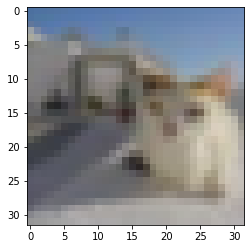

In [ ]:
# Before performing detailed enhancement
plt.imshow(  X_train[80]  )
plt.show()

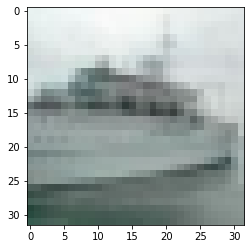

In [ ]:
# Before performing detailed enhancement
plt.imshow( X_test[80] )
plt.show()

In [ ]:
# Perform detailEnhancement ( operation similar to sharpening)
for every in tqdm(range( len(X_train) ) ):
  X_train[ every ] = cv2.detailEnhance(X_train[ every ] , sigma_s=10, sigma_r=0.15)

for every in tqdm(range( len(X_test) ) ):
  X_test[ every ] = cv2.detailEnhance(X_test[ every ] , sigma_s=10, sigma_r=0.15)

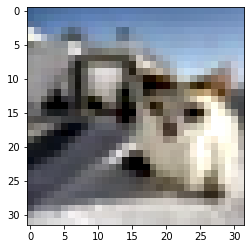

In [ ]:
# After performing detail enchancement
plt.imshow(  X_train[ 80 ]  )
plt.show()

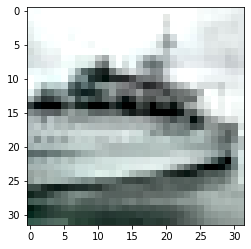

In [ ]:
# After performing detail enchancement
plt.imshow( X_test[80] )
plt.show()

In [ ]:
X_train = X_train/255.
X_test = X_test / 255.

In [ ]:
#Image Data Generator

# Using laplace flter with modification to sharpen the images
# Idea here is to see whether , sharpened text will lead to better results or not.

# def sharpen_laplace_with_addition(img):
#   kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
#   return (cv2.filter2D(img, -1, kernel))


def detail_enhancement( img ):
  return cv2.detailEnhance(img , sigma_s=10, sigma_r=0.15)

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(            

                                                         featurewise_std_normalization = True, 
                                                          # rotation_range = 90,   # 22.5 , 45 , 90
                                                          width_shift_range= 0.1,
                                                          height_shift_range= 0.1 ,
                                                          # zca_whitening=True,
                                                          #shear_range = 30 ,
                                                          zca_epsilon=1e-06,
                                                          horizontal_flip = True,
                                                          #brightness_range=[0.1, 0.2]

                                                        )

datagen.fit(X_train)

train_datagen = datagen.flow(x = X_train, y = y_train, batch_size = 64 )
test_datagen = datagen.flow(x = X_test, y = y_test, batch_size = 64 )

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:348: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
#### Chosen working model that gives test accuracy above 90% ::

In [ ]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0):
    global compression
    temp = input
    for _ in range(l):  # Controlling the depth
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(  int(num_filter*compression), (3,3),kernel_initializer = 'he_normal' , bias_initializer = 'glorot_uniform',
                                                                  use_bias=False ,padding='same')(relu)               # Eg : 12 * 0.5 = 6  filters   , kernel_regularizer = tf.keras.regularizers.l2( 0.0005 ) 

        # Conv2D_3_3 = layers.DepthwiseConv2D((3,3), (1,1) , depth_multiplier = 1 , depthwise_initializer =  'he_uniform' , 
        #                                                           use_bias=True , padding='same' )(relu)

        # Conv2D_3_3 = layers.SeparableConv2D( int(num_filter*compression), (3,3) , depthwise_initializer =  'he_uniform' ,   depthwise_regularizer = tf.keras.regularizers.l2(0.005),
        #                                                           use_bias=True , padding='same')(relu)

        # if dropout_rate>0:
        #     Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)


        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        temp = concat
        
    return temp

## transition Block
def transition(input, num_filter = 12, dropout_rate = 0):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(    int(num_filter*compression), (1,1), kernel_initializer= 'he_uniform', use_bias=True , bias_initializer = 'he_normal',
                                                                           padding='same'   )(relu)

    # if dropout_rate>0:
    #      Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)

    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2) )(relu)   # By default the stride is 2 for Average pooling

    one_cross_one = layers.Conv2D(10, (1,1), use_bias=True ,padding='same' ,  kernel_initializer= 'he_uniform', bias_initializer = 'he_normal', name = 'one_cross_one_convoulution')(AvgPooling)
    output_replacement = layers.GlobalMaxPooling2D( name = 'globalpooling')(one_cross_one)
    output = layers.Activation('softmax')(output_replacement)

    return output

In [ ]:
# Model 
# Hyperparameters
l = 10                                                # number of Dense blocks aka depth
num_filter = 42
compression = 0.5
dropout_rate = 0

input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D( 64 , (3,3), use_bias=True ,padding='same', kernel_initializer = 'he_uniform', bias_initializer = 'he_normal',  kernel_regularizer = tf.keras.regularizers.l2( 0.0005 )  )(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [ ]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Nadam(learning_rate =  0.001),
              # optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, ),
              #optimizer=tf.keras.optimizers.SGD( momentum = 0.9, nesterov = True),
              metrics=['accuracy'])

In [ ]:
os.getcwd()

'/content/drive/My Drive'

In [ ]:
import datetime
log_dir="logs/fit1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,write_grads=True)

In [ ]:
def lr_schedule(epoch, lr = 0.003):
    '''Takes in the epoch and learning rate and returns the modified learning rate based on the epoch count
    '''
    if epoch > 250:
        lr = 0.00006
    elif epoch > 125:
        lr = 0.0003
    elif epoch <125:
      lr = 0.001
    return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [ ]:
filepath="./checkpoint/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True ,  mode='max')

In [ ]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    ''' Inherits from the tf.keras.callbacks.Callbacks
        Functionality :: It stops the model training when either of Two following conditions are met  ::
        
        1) The difference between  ( Train and Test accuracy is  2%) and ( Test accuracy is >= The threshold value set)
        
        2) When the model's Test accuracy is >= to the Set Threshold value desired.
        
    '''

    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        test_accuracy = logs["val_accuracy"]
        train_accuracy = logs['accuracy']
        if test_accuracy >= self.threshold   and  ( abs(train_accuracy - test_accuracy) < 2 )  :
            print('###' * 15)
            print('Stopping model training as objectives are met , difference between train and test = 2% !!')
            print('###' * 15)
            self.model.stop_training = True

        elif  test_accuracy >= self.threshold :
            print('###' * 15)
            print('Stopping model training as objectives are met !!')
            print('###' * 15)
            self.model.stop_training = True

stop_training =MyThresholdCallback(  threshold = 0.9  )                   # Setting a threshold of 90%  as that is out objective

In [ ]:
# How to save model in tensorflow
# https://www.tensorflow.org/api_docs/python/tf/keras/models/save_model

In [ ]:
batch_size = 64   # 128
epochs_value = 300
train_steps_value = X_train.shape[0] // batch_size                                         # Eg :: Train steps = 50000 / 64 = 781 
validation_steps_value = X_test.shape[0] // batch_size                 # Eg:: Validation steps = 10000 / 64 = 156
print( train_steps_value, validation_steps_value )

history = model.fit_generator( train_datagen , steps_per_epoch = train_steps_value,   epochs = epochs_value  , validation_data = test_datagen , 
                               callbacks = [ tensorboard_callback, checkpoint, lr_scheduler , stop_training ]  ,  validation_steps = validation_steps_value )


781 156
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/300
781/781 [==============================] - ETA: 0s - loss: 1.3496 - accuracy: 0.5298
Epoch 00001: val_accuracy improved from -inf to 0.60086, saving model to ./checkpoint/weights-01-0.6009.hdf5
781/781 [==============================] - 68s 87ms/step - loss: 1.3496 - accuracy: 0.5298 - val_loss: 1.2035 - val_accuracy: 0.6009 - lr: 0.0010
Epoch 2/300
781/781 [==============================] - ETA: 0s - loss: 0.9303 - accuracy: 0.6869
Epoch 00002: val_accuracy improved from 0.60086 to 0.63131, saving model to ./checkpoint/weights-02-0.6313.hdf5
781/781 [==============================] - 67s 85ms/step - loss: 0.9303 - accuracy: 0.6869 - val_loss: 1.1814 - val_accuracy: 0.6313 - lr: 0.0010
Epoch 3/300
781/781 [==============================] - ETA: 0s - loss: 0.7796 - accuracy: 0.7413
Epoch 00003: val_accuracy improved from 0.63131 to 0.72927, saving model to ./checkpoint/weights-03-0.7293.hdf5


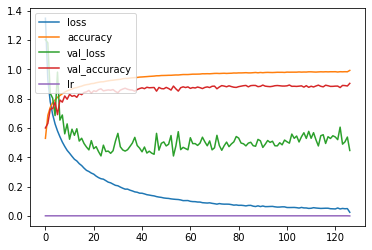

In [ ]:
import pandas as pd
hold_history = pd.DataFrame(dict(model.history.history))
hold_history.to_csv( 'saved_model1.csv',  index = False )
hold_history = pd.read_csv('/content/drive/My Drive/saved_model1.csv')
hold_history.plot()

In [ ]:
# pd.read_csv('/content/drive/My Drive/saved_model1.csv')
hold_history

,loss,accuracy,val_loss,val_accuracy,lr
0,1.349607,0.529850,1.203496,0.600861,0.0010
1,0.930302,0.686919,1.181446,0.631310,0.0010
2,0.779591,0.741309,0.836913,0.729267,0.0010
3,0.692505,0.772989,0.804176,0.733474,0.0010
4,0.628102,0.791914,0.685013,0.776042,0.0010
...,...,...,...,...,...
122,0.047873,0.984620,0.606236,0.876502,0.0010
123,0.051340,0.983939,0.490167,0.891026,0.0010
124,0.049245,0.984720,0.505763,0.890024,0.0010
125,0.050183,0.984100,0.538589,0.887119,0.0010


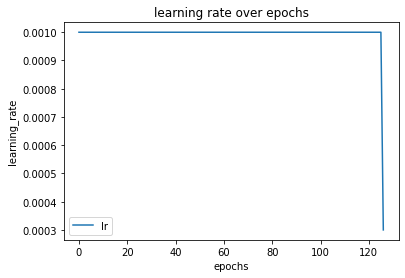

In [ ]:
hold_history[ ['lr']].plot()
plt.ylabel('learning_rate')
plt.xlabel('epochs')
plt.title('learning rate over epochs')
plt.show()

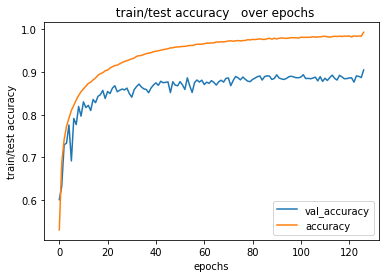

In [ ]:
hold_history[ ['val_accuracy', 'accuracy'] ].plot()
plt.ylabel('train/test accuracy')
plt.xlabel('epochs')
plt.title('  train/test accuracy   over epochs')
plt.show()

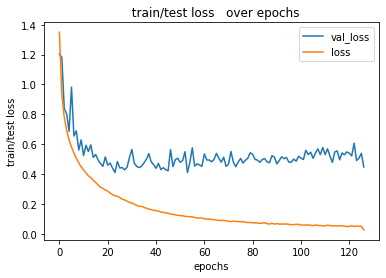

In [ ]:
hold_history[ ['val_loss', 'loss'] ].plot()
plt.ylabel('train/test loss')
plt.xlabel('epochs')
plt.title('  train/test loss   over epochs')
plt.show()

In [ ]:
## Observations, Other Experiments and results  with Cyclical Learning rate schedulers::

### 1) *Normal Conv2d with Cyclical learning rates  having 457,000 Params ::*

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML

In [ ]:
print('Params Proof \nFig 1 :: ')
Image(url= "https://i.imgur.com/IEjQ3zg.png")

Params Proof 
Fig 1 :: 


In [ ]:
print('Epochs until 84% test accuracy:   \nFig 2 :: ')
Image(url= "https://i.imgur.com/AIz8ACP.png")

Epochs until 84% test accuracy:   
Fig 2 :: 


In [ ]:
print('Result of searching Learning rate via Learning rate Scheduler \nFig 3 :: ')
Image(url= "https://i.imgur.com/bQsCCc1.png")

Result of searching Learning rate via Learning rate Scheduler 
Fig 3 :: 


In [ ]:
print('Triangular2 Learning rate \nFig 4 :: ')
Image(url= "https://i.imgur.com/VBW6gRm.png")

Triangular2 Learning rate 
Fig 4 :: 


In [ ]:
print('Results after 10 epochs \nFig 5 :: ')
Image(url= "https://i.imgur.com/1pIMj7u.png")

Results after 10 epochs 
Fig 5 :: 


### 2) *Separable Conv2d with Cyclical learning rates  having 360,000 Params ::*

In [ ]:
print('Params   \nFig 1 :: ')
Image(url= "https://i.imgur.com/UTRCTHe.png")

Params   
Fig 1 :: 


In [ ]:
print('Cyclic learning rate scheduler example usage  \nFig 2 :: ')
Image(url= "https://i.imgur.com/8rfAEpq.png")

Cyclic learning rate scheduler example usage  
Fig 2 :: 


In [ ]:
print('Epochs until 84% test accuracy:   \nFig 3 :: ')
Image(url= "https://i.imgur.com/AIz8ACP.png")

Epochs until 84% test accuracy:   
Fig 3 :: 


In [ ]:
print('Learning rate finder \nFig 4 :: ')
Image(url= "https://i.imgur.com/GwH0B8h.png")

Learning rate finder 
Fig 4 :: 


In [ ]:
print('Triangluar2 Learning rate \nFig 5 :: ')
Image(url= "https://i.imgur.com/b6EeiHS.png")

Triangluar2 Learning rate 
Fig 5 :: 


In [ ]:
print('Learning rate finder for model from 10 to 20th epoch  \nFig 6 :: ')
Image(url= "https://i.imgur.com/hdeIDz8.png")

Learning rate finder for model from 10 to 20th epoch  
Fig 6 :: 


In [ ]:
print('Results after 10 epochs  \nFig 7 :: ')
Image(url= "https://i.imgur.com/gFH28OV.png")

Results after 10 epochs  
Fig 7 :: 


### 3) *Normal Conv2d with Cyclical learning rates  having 986,000 Params ::*

In [ ]:
print('Params   \nFig 1 :: ')
Image(url= "https://i.imgur.com/RRAW7Ow.png")

Params   
Fig 1 :: 


In [ ]:
print('Epochs until 84% test accuracy:   \nFig 2 :: ')
Image(url= "https://i.imgur.com/AS5wVEK.png")

Epochs until 84% test accuracy:   
Fig 2 :: 


In [ ]:
print('Epochs until 85% test accuracy:   \nFig 3 :: ')
Image(url= "https://i.imgur.com/LNemTnb.png")

Epochs until 85% test accuracy:   
Fig 3 :: 


In [ ]:
print('Results after 15 epochs:   \nFig 4 :: ')
Image(url= "https://i.imgur.com/vYbpEkz.png")


Results after 15 epochs:   
Fig 4 :: 


In [ ]:
print(' learning rate with cyclical learning rate scheduler:   \nFig 5 :: ')
Image(url= "https://i.imgur.com/N4Y4jYZ.png")

 learning rate with cyclical learning rate scheduler:   
Fig 5 :: 


In [ ]:
print('Accuracy and loss plots:   \nFig 6 :: ')
Image(url= "https://i.imgur.com/7tj0rip.png")

Accuracy and loss plots:   
Fig 6 :: 


In [ ]:
print('Using different optimizer for saved models:   \nFig 7 :: ')
Image(url= "https://i.imgur.com/e8aJrLz.png")

Using different optimizer for saved models:   
Fig 7 :: 


In [ ]:
print('Result after 20 Epochs   \nFig 8 :: ')
Image(url= "https://i.imgur.com/ikg5b5M.png")

Result after 20 Epochs   
Fig 8 :: 


### Observations ::

#### 1)  Chosen Working model, Normal Conv2d with 986,000  trainable Params and Step decay learning rate scheduler ::

* This model uses __986,000  parameters__ , with no dropouts and  __Takes 127 epochs to cross 90% threshold for Test set__ , however, it overfits  as it uses  a 
    Simple learning rate scheduler with __step decay__, The chosen optimizer after repeated experimentation was Nadam , as it gave faster convergence  when
    compared to SGD with Momentum and Adam.

* The best  batch size was found to be 64 , which gave the best results in lesser number of epochs compared to other batch sizes i.e 128 and 256 .

* Further experimentation with L1, L2 and L1_L2 regularizers has increased the __time taken to Run an epoch by 5  Times__, whilst giving no significant improvement in    the results.

* We can Further observe that the __Test loss__ seldom decreased below 0.4 with this model.

#### Reason for using Cyclical learning rate schedulers ::
1) Please Refer :: https://arxiv.org/abs/1506.01186

2) Sample notebook on generating cyclical learning rates :: https://github.com/bckenstler/CLR/blob/master/clr_callback_tests.ipynb

#### 2)  Conv2d Separable results ( 360,000 total params)  with Cyclic learning rate scheduler::

* This model takes significantly , i.e 1/3 of the number of params as the chosen model , and performs on par with it controlling for all the same conditions
    ,When run for 150 epochs , it does not overfit  like the chosen model.

*  This model uses the __cyclic learning rate scheduler__ as  mentioned in the __Paper Titled :: Cyclical Learning Rates for Training Neural Networks - Leslie Smith__
    It uses a Triangular2 periodic learning rate with 1562 , i.e  2 times the iterations as the step size,(recommended is between 2 -8 times the iterations(train steps) )
    
* We are able to achieve __84% accuracy with Test set and less than 3% difference between train and test accuracy in 8 epochs only__ .

* When this model was Ran for  35 epochs , The results were 88 % Test accuracy and 91 % Train accuracy , to get the same comparable result 
   from the Chosen model , we had to wait until 54th epoch but, we can see the difference, The chosen model is a bad performer, as it overfits a lot, 
   i.e 96  % Train and 88 % test .

* One of the reasons why this model  performs better in Contrast to the Chosen model is 
    ,__Cyclic Learning rates help us to converge faster than the traditional  learning rate decay methods__ .
    
* There are instances where 88 % accuracy on test Data set was achieved in less than __15 epochs__ with  difference between train and test accuracies <= 3 %


* Here we have  __performed a gridsearch kind of a technique for finding The best Range of Initial Learning rate__ for the model to begin with , 
    more information on this can be found out in the same  paper by Leslie Smith (Link :: https://arxiv.org/abs/1506.01186  )
    
    
* Here in this model, the  __best reduction in test loss  which is ( 0.35)  was seen for 88% Test accuracy__, which is better by huge margin compared to previous model.

In [ ]:
#### 3)  Normal Conv2d with 460,000 trainable Params   with Cyclic learning rate scheduler :: 

* The performance  of this model
    almost Similar to the Conv2d Separable , same techniques of using learning rate finder and cyclic learning rates were used here as well.

In [ ]:
#### 4) Normal Conv2d with 986,000 trainable Params with Cyclic learning rate scheduler::

* This model has the same design  as the Chosen model, The difference here is the use of Gridsearch like techinique to find the best intial learning rate for the model
    to begin with and the use of Cyclical learning rate schedulers.
    
* This model used both Triangular2 and exp_range which gradually decays the Traingular.

* As observed in other models with cyclical learning rate schedulers , this model fits the same pattern, of converging in less number of epochs,
    ( i.e best one was 89% test accuracy at 12th epoch)  with very minimal overfitting to training data set.


* Models were also run with Regularizers , but did not show significant improvement, as regularizers are not alternatives to Dropouts. Also, regularizers increase the 
   Time taken to complete one epoch by _5 times _ when regularizers were not used.

#### 5 ) Normal Conv2d With 986,000  trainable params SGD optimizer, as mentioned in the Densenet Paper ::

*  As mentioned in the Densenet Paper which used SGD with momentum , and 300 epochs,  and 1 Million params. 
   __Link to paper - (https://arxiv.org/abs/1608.06993)__
* Similar settings were tried with Dropouts = 0, and the test accuracy did not cross 88% even after 200 epochs even after using step decay with values 
   mentioned in the Paper.

In [ ]:
### References ::

1) https://www.learnopencv.com/non-photorealistic-rendering-using-opencv-python-c/

2) https://stackoverflow.com/questions/33022578/improve-image-quality

3) machinecurve.com/index.php/2019/09/24/creating-depthwise-separable-convolutions-in-keras/#

4)  https://keras.io/api/layers/convolution_layers/depthwise_convolution2d/


5) https://stackoverflow.com/questions/53500047/stop-training-in-keras-when-accuracy-is-already-1-0

6) https://towardsdatascience.com/a-bunch-of-tips-and-tricks-for-training-deep-neural-networks-3ca24c31ddc8

7) https://www.youtube.com/watch?v=gmr18xg4wTg



##### Cyclic learning rate schedulers 
8) https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/CyclicalLearningRate

9) https://www.pyimagesearch.com/2019/09/23/keras-starting-stopping-and-resuming-training/

10) https://www.pyimagesearch.com/2019/07/29/cyclical-learning-rates-with-keras-and-deep-learning/

11) https://github.com/bckenstler/CLR

12) https://www.jeremyjordan.me/nn-learning-rate/

13) https://medium.com/octavian-ai/how-to-use-the-learning-rate-finder-in-tensorflow-126210de9489

14) https://www.pyimagesearch.com/2019/08/05/keras-learning-rate-finder/

15) https://github.com/psklight/keras_one_cycle_clr


#### Papers referred and videos  ::
 16) Cyclical Learning Rates for Training Neural Networks  - Leslie Smith ( https://arxiv.org/abs/1506.01186 ) 
        
 17) Competition Winning Learning Rates -  https://www.youtube.com/watch?v=bR7z2MA0p-o .

#### Errors
17)  https://stackoverflow.com/questions/55112713/earlystopping-object-has-no-attribute-on-train-batch-begin/55114607

##### Editing Colab packages
18)https://stackoverflow.com/questions/56917299/how-to-edit-google-colaboratory-libraries

##### Learning rate finder
20) https://github.com/surmenok/keras_lr_finder

21) https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0

##### Miscellaneous ::
22) https://stackoverflow.com/questions/33759623/tensorflow-how-to-save-restore-a-model/58073719#58073719

23) https://stackoverflow.com/questions/47523841/using-keras-to-load-model-and-assign-new-values-to-its-parameters


##### Types on Convolution ::
24) https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215

25) https://ikhlestov.github.io/pages/machine-learning/convolutions-types/

26) https://www.youtube.com/watch?v=gmr18xg4wTg

27) https://www.youtube.com/watch?v=T7o3xvJLuHk

28) https://www.youtube.com/channel/UCNXHr_mzoplvXy0crvhJKRg